# Pytorch 


In [ ]:
import glob
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import masks_to_boxes
from torchvision.io import read_image
from prettytable import PrettyTable
from segment_anything import sam_model_registry
from torch.nn.functional import threshold, normalize
from segment_anything.utils.transforms import ResizeLongestSide

NUM_VIEWS_PER_SCENE = 6
TOD_filepath = 'C:/dataset/TOD/preprocessed/'

# Utils Functions
def get_bounding_boxes(mask):
    obj_ids = torch.unique(mask)
    obj_ids = obj_ids[1:]
    masks = mask == obj_ids[:, None, None]
    boxes = masks_to_boxes(masks).detach().numpy()
    if boxes.all()==None:
        boxes=np.array([])
    return boxes

def array_to_tensor(array):
    """ Converts a numpy.ndarray (N x H x W x C) to a torch.FloatTensor of shape (N x C x H x W)
        OR
        converts a nump.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W)
    """
    if array.ndim == 4: # NHWC
        tensor = torch.from_numpy(array).permute(0,3,1,2).float()
    elif array.ndim == 3: # HWC
        tensor = torch.from_numpy(array).permute(2,0,1).float()
    else: # everything else
        tensor = torch.from_numpy(array).float()

    return tensor


# Visualization & Ploting Functions
def visualize_segmentation(im, masks, nc=None):
    """ Visualize segmentations nicely. Based on code from:
        https://github.com/roytseng-tw/Detectron.pytorch/blob/master/lib/utils/vis.py

        @param im: a [H x W x 3] RGB image. numpy array of dtype np.uint8
        @param masks: a [H x W] numpy array of dtype np.uint8 with values in {0, ..., nc-1}
        @param nc: total number of colors. If None, this will be inferred by masks

        @return: a [H x W x 3] numpy array of dtype np.uint8
    """ 
    masks = masks.astype(int)
    im = im.copy()

    # Generate color mask
    if nc is None:
        NUM_COLORS = masks.max() + 1
    else:
        NUM_COLORS = nc

    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1. * i/NUM_COLORS) for i in range(NUM_COLORS)]

    # Mask
    imgMask = np.zeros(im.shape)


    # Draw color masks
    for i in np.unique(masks):
        if i == 0: # background
            continue

        # Get the color mask
        color_mask = np.array(colors[i][:3])
        w_ratio = .4
        for c in range(3):
            color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
        e = (masks == i)

        # Add to the mask
        imgMask[e] = color_mask

    # Add the mask to the image
    imgMask = (imgMask * 255).round().astype(np.uint8)
    im = cv2.addWeighted(im, 0.5, imgMask, 0.5, 0.0)


    # Draw mask contours
    for i in np.unique(masks):
        if i == 0: # background
            continue

        # Get the color mask
        color_mask = np.array(colors[i][:3])
        w_ratio = .4
        for c in range(3):
            color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
        e = (masks == i)

        # Find contours
        contour, hier = cv2.findContours(
            e.astype(np.uint8).copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

        # Plot the nice outline
        for c in contour:
            cv2.drawContours(im, contour, -1, (255,255,255), 2)

    return im

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# # Ref: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

def show_bbox_and_mask(rgb_img, bbox, mask_img):
    seg_img=visualize_segmentation(rgb_img,mask_img)
    fig = plt.figure(figsize=(10, 10)) 
    
    fig.add_subplot(1, 3, 1) 
    plt.imshow(rgb_img)
    for box in bbox:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.title("BBOX")

    fig.add_subplot(1, 3, 2) 
    plt.imshow(mask_img)
    plt.axis('on')
    plt.title("MASK")

    fig.add_subplot(1, 3, 3) 
    plt.imshow(seg_img)
    plt.axis('on')
    plt.title("Segmentation")
    plt.show()

c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(1, 256, 64, 64) (3, 4)


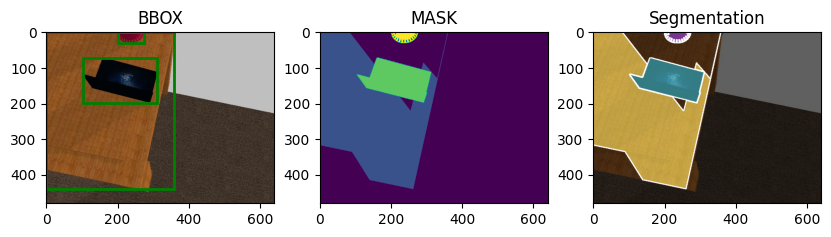

In [ ]:
scene_dirs=sorted(glob.glob(TOD_filepath + '*/'))
start_idx= 41
end_idx=42
for idx in range(start_idx,end_idx):
    # Get scene directory
    scene_idx = idx // NUM_VIEWS_PER_SCENE
    scene_dir = scene_dirs[scene_idx]

    # Get view number
    view_num = (idx % NUM_VIEWS_PER_SCENE)+1
    
    # Load Data
    image_filename = scene_dir + f"image_{view_num:05d}.npy"
    mask_filename = scene_dir + f"mask_{view_num:05d}.npy"
    embeddings_filename = scene_dir + f"embeddings_{view_num:05d}.npy"
    boxes_filename = scene_dir + f"boxes_{view_num:05d}.npy"
    
    image = np.load(image_filename)            # Shape: (480, 640, 3)    
    mask = np.load(mask_filename)              # Shape: (1, 480, 640)    
    embeddings = np.load(embeddings_filename)  # Shape: (1, 256, 64, 64)
    boxes = np.load(boxes_filename)            # Shape: (*, 4)
    print(embeddings.shape, boxes.shape)
    show_bbox_and_mask(image, boxes, mask[0])

In [ ]:
# https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/finetune_and_inference_tutorial_2D_dataset.ipynb
checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"
model_save_path = "model"

sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
count_parameters(sam_model)
sam_model.train()
for name, param in sam_model.named_parameters():
  if name.startswith("image_encoder") or name.startswith('mask_decoder'):
    param.requires_grad_(False)

+-----------------------------------------------------------------------------+------------+
|                                   Modules                                   | Parameters |
+-----------------------------------------------------------------------------+------------+
|                           image_encoder.pos_embed                           |  5242880   |
|                    image_encoder.patch_embed.proj.weight                    |   983040   |
|                     image_encoder.patch_embed.proj.bias                     |    1280    |
|                     image_encoder.blocks.0.norm1.weight                     |    1280    |
|                      image_encoder.blocks.0.norm1.bias                      |    1280    |
|                    image_encoder.blocks.0.attn.rel_pos_h                    |    2160    |
|                    image_encoder.blocks.0.attn.rel_pos_w                    |    2160    |
|                    image_encoder.blocks.0.attn.qkv.weight           

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

def worker_init_fn(worker_id):
    """ Use this to bypass issue with PyTorch dataloaders using deterministic RNG for Numpy
        https://github.com/pytorch/pytorch/issues/5059
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)

class Tabletop_Object_Dataset(Dataset):
    """ Data loader for Tabletop Object Dataset
    """
    def __init__(self, base_dir):
        self.base_dir = base_dir
        # Get a list of all scenes
        self.scene_dirs = sorted(glob.glob(self.base_dir + '*/'))

    def __len__(self):
        return len(self.scene_dirs) * NUM_VIEWS_PER_SCENE

    def __getitem__(self, idx):

        cv2.setNumThreads(0) # some hack to make sure pyTorch doesn't deadlock. Found at https://github.com/pytorch/pytorch/issues/1355. Seems to work for me
    
        # Get scene directory
        scene_idx = idx // NUM_VIEWS_PER_SCENE
        scene_dir = self.scene_dirs[scene_idx]

        # Get view number
        view_num = (idx % NUM_VIEWS_PER_SCENE)+1

        # Load Data
        # image_filename = scene_dir + f"image_{view_num:05d}.npy"
        mask_filename = scene_dir + f"mask_{view_num:05d}.npy"
        embeddings_filename = scene_dir + f"embeddings_{view_num:05d}.npy"
        boxes_filename = scene_dir + f"boxes_{view_num:05d}.npy"
        
        # image = np.load(image_filename)            # Shape: (480, 640, 3)    
        mask = np.load(mask_filename)              # Shape: (1, 480, 640)    
        embeddings = np.load(embeddings_filename)  # Shape: (1, 256, 64, 64)
        boxes = np.load(boxes_filename)            # Shape: (*, 4)
        
        return embeddings, mask, boxes
    
dataset = Tabletop_Object_Dataset(TOD_filepath)
dl = DataLoader(dataset=dataset, batch_size=10, shuffle=True, collate_fn=collate_fn, worker_init_fn=worker_init_fn)
# dl = DataLoader(dataset=dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, worker_init_fn=worker_init_fn)

dataset.__len__(), len(dl)

(2100, 210)

In [ ]:
class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        # comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.nn.functional.sigmoid(inputs)       
        
        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [ ]:
count_parameters(sam_model)
# Adam(sam_model.prompt_encoder.parameters(), lr=1e-5, weight_decay=0)
optimizer = torch.optim.Adam(sam_model.prompt_encoder.parameters()) # Default lr = 0.001
# criterion_mse = torch.nn.MSELoss()
# criterion_bce = torch.nn.BCELoss()
criterion_dice = DiceLoss()

+------------------------------------------+------------+
|                 Modules                  | Parameters |
+------------------------------------------+------------+
| prompt_encoder.point_embeddings.0.weight |    256     |
| prompt_encoder.point_embeddings.1.weight |    256     |
| prompt_encoder.point_embeddings.2.weight |    256     |
| prompt_encoder.point_embeddings.3.weight |    256     |
| prompt_encoder.not_a_point_embed.weight  |    256     |
| prompt_encoder.mask_downscaling.0.weight |     16     |
|  prompt_encoder.mask_downscaling.0.bias  |     4      |
| prompt_encoder.mask_downscaling.1.weight |     4      |
|  prompt_encoder.mask_downscaling.1.bias  |     4      |
| prompt_encoder.mask_downscaling.3.weight |    256     |
|  prompt_encoder.mask_downscaling.3.bias  |     16     |
| prompt_encoder.mask_downscaling.4.weight |     16     |
|  prompt_encoder.mask_downscaling.4.bias  |     16     |
| prompt_encoder.mask_downscaling.6.weight |    4096    |
|  prompt_enco

In [ ]:
num_epochs=5
losses=[]
with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/sam_train'),
        record_shapes=True,
        with_stack=True
) as prof:
    for epoch in range(num_epochs):
        batch_losses=[]
        for step, (embeddings, masks, boxes) in enumerate(tqdm(dl, desc=f"EPOCH {epoch}: ")):
        # for step, (embeddings, masks, boxes) in enumerate(dl):
            assert len(embeddings) == len(masks) == len(boxes)
            for i in range(len(embeddings)): 
                # print(step, " " ,i)
                # print(embeddings[i].shape) # (1, 256, 64, 64)
                # print(masks[i].shape)      # (1, 480, 640)
                # print(boxes[i].shape)      # (*, 4)
                # # print("------------------------")
                if boxes[i].shape[0]==0:
                    continue
                sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                    points=None,
                    boxes=torch.tensor(boxes[i]).to(device),
                    masks=None,
                )
                # print(sparse_embeddings.shape, dense_embeddings.shape)
                low_res_masks, iou_predictions = sam_model.mask_decoder(
                    image_embeddings=torch.tensor(embeddings[i]).to(device), # Shape: (1, 256, 64, 64)
                    image_pe=sam_model.prompt_encoder.get_dense_pe(),        # Shape: (1, 256, 64, 64)
                    sparse_prompt_embeddings=sparse_embeddings,              # Shape: (*, 2, 256) 
                    dense_prompt_embeddings=dense_embeddings,                # Shape: (*, 256, 64, 64)
                    multimask_output=False,
                ) 
                # print(low_res_masks.shape, iou_predictions.shape)

                upscaled_masks = sam_model.postprocess_masks(low_res_masks, (1024, 1024), (480, 640)).to(device)
                binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))             # Shape: (*, 1, 480, 640)
                binary_mask = torch.sum(binary_mask, 0)                                # Shape: (1, 480, 640)
                
                # prediction_mask = np.sum(prediction_mask.cpu().detach().numpy(), axis=0)       # Shape: (1, 480, 640)
                loss = criterion_dice(binary_mask.to(float), torch.tensor(masks[i]).to(float).to(device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                batch_losses.append(loss.item())
        losses.append(sum(batch_losses)/len(batch_losses):.05)
        print(f'EPOCH: {epoch}, Loss: {sum(batch_losses)/len(batch_losses):.05}')
        prof.step() # Need to call this at the end of each step to notify profiler of steps' boundary.

EPOCH 0: 100%|██████████| 210/210 [02:09<00:00,  1.62it/s]


EPOCH: 0, Loss: 0.78522


EPOCH 1: 100%|██████████| 210/210 [02:02<00:00,  1.72it/s]


EPOCH: 1, Loss: 0.74066


EPOCH 2: 100%|██████████| 210/210 [02:08<00:00,  1.63it/s]


EPOCH: 2, Loss: 0.79656


EPOCH 3: 100%|██████████| 210/210 [02:09<00:00,  1.62it/s]


EPOCH: 3, Loss: 0.72894


EPOCH 4: 100%|██████████| 210/210 [02:10<00:00,  1.61it/s]

In [ ]:
losses

In [1]:
import glob
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import masks_to_boxes
from torchvision.io import read_image
from prettytable import PrettyTable
from segment_anything import sam_model_registry
from torch.nn.functional import threshold, normalize
from segment_anything.utils.transforms import ResizeLongestSide

NUM_VIEWS_PER_SCENE = 6
TOD_filepath = 'C:/dataset/TOD/preprocessed/'

# Utils Functions
def get_bounding_boxes(mask):
    obj_ids = torch.unique(mask)
    obj_ids = obj_ids[1:]
    masks = mask == obj_ids[:, None, None]
    boxes = masks_to_boxes(masks).detach().numpy()
    if boxes.all()==None:
        boxes=np.array([])
    return boxes

def array_to_tensor(array):
    """ Converts a numpy.ndarray (N x H x W x C) to a torch.FloatTensor of shape (N x C x H x W)
        OR
        converts a nump.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W)
    """
    if array.ndim == 4: # NHWC
        tensor = torch.from_numpy(array).permute(0,3,1,2).float()
    elif array.ndim == 3: # HWC
        tensor = torch.from_numpy(array).permute(2,0,1).float()
    else: # everything else
        tensor = torch.from_numpy(array).float()

    return tensor


# Visualization & Ploting Functions
def visualize_segmentation(im, masks, nc=None):
    """ Visualize segmentations nicely. Based on code from:
        https://github.com/roytseng-tw/Detectron.pytorch/blob/master/lib/utils/vis.py

        @param im: a [H x W x 3] RGB image. numpy array of dtype np.uint8
        @param masks: a [H x W] numpy array of dtype np.uint8 with values in {0, ..., nc-1}
        @param nc: total number of colors. If None, this will be inferred by masks

        @return: a [H x W x 3] numpy array of dtype np.uint8
    """ 
    masks = masks.astype(int)
    im = im.copy()

    # Generate color mask
    if nc is None:
        NUM_COLORS = masks.max() + 1
    else:
        NUM_COLORS = nc

    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1. * i/NUM_COLORS) for i in range(NUM_COLORS)]

    # Mask
    imgMask = np.zeros(im.shape)


    # Draw color masks
    for i in np.unique(masks):
        if i == 0: # background
            continue

        # Get the color mask
        color_mask = np.array(colors[i][:3])
        w_ratio = .4
        for c in range(3):
            color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
        e = (masks == i)

        # Add to the mask
        imgMask[e] = color_mask

    # Add the mask to the image
    imgMask = (imgMask * 255).round().astype(np.uint8)
    im = cv2.addWeighted(im, 0.5, imgMask, 0.5, 0.0)


    # Draw mask contours
    for i in np.unique(masks):
        if i == 0: # background
            continue

        # Get the color mask
        color_mask = np.array(colors[i][:3])
        w_ratio = .4
        for c in range(3):
            color_mask[c] = color_mask[c] * (1 - w_ratio) + w_ratio
        e = (masks == i)

        # Find contours
        contour, hier = cv2.findContours(
            e.astype(np.uint8).copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

        # Plot the nice outline
        for c in contour:
            cv2.drawContours(im, contour, -1, (255,255,255), 2)

    return im

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# # Ref: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

def show_bbox_and_mask(rgb_img, bbox, mask_img):
    seg_img=visualize_segmentation(rgb_img,mask_img)
    fig = plt.figure(figsize=(10, 10)) 
    
    fig.add_subplot(1, 3, 1) 
    plt.imshow(rgb_img)
    for box in bbox:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.title("BBOX")

    fig.add_subplot(1, 3, 2) 
    plt.imshow(mask_img)
    plt.axis('on')
    plt.title("MASK")

    fig.add_subplot(1, 3, 3) 
    plt.imshow(seg_img)
    plt.axis('on')
    plt.title("Segmentation")
    plt.show()

c:\Users\divya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(1, 256, 64, 64) (3, 4)


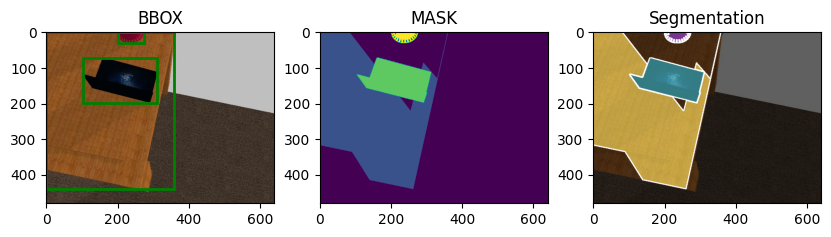

In [43]:
scene_dirs=sorted(glob.glob(TOD_filepath + '*/'))
start_idx= 41
end_idx=42
for idx in range(start_idx,end_idx):
    # Get scene directory
    scene_idx = idx // NUM_VIEWS_PER_SCENE
    scene_dir = scene_dirs[scene_idx]

    # Get view number
    view_num = (idx % NUM_VIEWS_PER_SCENE)+1
    
    # Load Data
    image_filename = scene_dir + f"image_{view_num:05d}.npy"
    mask_filename = scene_dir + f"mask_{view_num:05d}.npy"
    embeddings_filename = scene_dir + f"embeddings_{view_num:05d}.npy"
    boxes_filename = scene_dir + f"boxes_{view_num:05d}.npy"
    
    image = np.load(image_filename)            # Shape: (480, 640, 3)    
    mask = np.load(mask_filename)              # Shape: (1, 480, 640)    
    embeddings = np.load(embeddings_filename)  # Shape: (1, 256, 64, 64)
    boxes = np.load(boxes_filename)            # Shape: (*, 4)
    print(embeddings.shape, boxes.shape)
    show_bbox_and_mask(image, boxes, mask[0])

In [2]:
# https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/finetune_and_inference_tutorial_2D_dataset.ipynb
checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"
model_save_path = "model"

sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
count_parameters(sam_model)
sam_model.train()
for name, param in sam_model.named_parameters():
  if name.startswith("image_encoder") or name.startswith('mask_decoder'):
    param.requires_grad_(False)

+-----------------------------------------------------------------------------+------------+
|                                   Modules                                   | Parameters |
+-----------------------------------------------------------------------------+------------+
|                           image_encoder.pos_embed                           |  5242880   |
|                    image_encoder.patch_embed.proj.weight                    |   983040   |
|                     image_encoder.patch_embed.proj.bias                     |    1280    |
|                     image_encoder.blocks.0.norm1.weight                     |    1280    |
|                      image_encoder.blocks.0.norm1.bias                      |    1280    |
|                    image_encoder.blocks.0.attn.rel_pos_h                    |    2160    |
|                    image_encoder.blocks.0.attn.rel_pos_w                    |    2160    |
|                    image_encoder.blocks.0.attn.qkv.weight           

In [3]:
def collate_fn(batch):
    return tuple(zip(*batch))

def worker_init_fn(worker_id):
    """ Use this to bypass issue with PyTorch dataloaders using deterministic RNG for Numpy
        https://github.com/pytorch/pytorch/issues/5059
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)

class Tabletop_Object_Dataset(Dataset):
    """ Data loader for Tabletop Object Dataset
    """
    def __init__(self, base_dir):
        self.base_dir = base_dir
        # Get a list of all scenes
        self.scene_dirs = sorted(glob.glob(self.base_dir + '*/'))

    def __len__(self):
        return len(self.scene_dirs) * NUM_VIEWS_PER_SCENE

    def __getitem__(self, idx):

        cv2.setNumThreads(0) # some hack to make sure pyTorch doesn't deadlock. Found at https://github.com/pytorch/pytorch/issues/1355. Seems to work for me
    
        # Get scene directory
        scene_idx = idx // NUM_VIEWS_PER_SCENE
        scene_dir = self.scene_dirs[scene_idx]

        # Get view number
        view_num = (idx % NUM_VIEWS_PER_SCENE)+1

        # Load Data
        # image_filename = scene_dir + f"image_{view_num:05d}.npy"
        mask_filename = scene_dir + f"mask_{view_num:05d}.npy"
        embeddings_filename = scene_dir + f"embeddings_{view_num:05d}.npy"
        boxes_filename = scene_dir + f"boxes_{view_num:05d}.npy"
        
        # image = np.load(image_filename)            # Shape: (480, 640, 3)    
        mask = np.load(mask_filename)              # Shape: (1, 480, 640)    
        embeddings = np.load(embeddings_filename)  # Shape: (1, 256, 64, 64)
        boxes = np.load(boxes_filename)            # Shape: (*, 4)
        
        return embeddings, mask, boxes
    
dataset = Tabletop_Object_Dataset(TOD_filepath)
dl = DataLoader(dataset=dataset, batch_size=10, shuffle=True, collate_fn=collate_fn, worker_init_fn=worker_init_fn)
# dl = DataLoader(dataset=dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, worker_init_fn=worker_init_fn)

dataset.__len__(), len(dl)

(2100, 210)

In [4]:
class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        # comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.nn.functional.sigmoid(inputs)       
        
        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [6]:
count_parameters(sam_model)
# Adam(sam_model.prompt_encoder.parameters(), lr=1e-5, weight_decay=0)
optimizer = torch.optim.Adam(sam_model.prompt_encoder.parameters()) # Default lr = 0.001
# criterion_mse = torch.nn.MSELoss()
# criterion_bce = torch.nn.BCELoss()
criterion_dice = DiceLoss()

+------------------------------------------+------------+
|                 Modules                  | Parameters |
+------------------------------------------+------------+
| prompt_encoder.point_embeddings.0.weight |    256     |
| prompt_encoder.point_embeddings.1.weight |    256     |
| prompt_encoder.point_embeddings.2.weight |    256     |
| prompt_encoder.point_embeddings.3.weight |    256     |
| prompt_encoder.not_a_point_embed.weight  |    256     |
| prompt_encoder.mask_downscaling.0.weight |     16     |
|  prompt_encoder.mask_downscaling.0.bias  |     4      |
| prompt_encoder.mask_downscaling.1.weight |     4      |
|  prompt_encoder.mask_downscaling.1.bias  |     4      |
| prompt_encoder.mask_downscaling.3.weight |    256     |
|  prompt_encoder.mask_downscaling.3.bias  |     16     |
| prompt_encoder.mask_downscaling.4.weight |     16     |
|  prompt_encoder.mask_downscaling.4.bias  |     16     |
| prompt_encoder.mask_downscaling.6.weight |    4096    |
|  prompt_enco

In [7]:
num_epochs=5
losses=[]
with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/sam_train'),
        record_shapes=True,
        with_stack=True
) as prof:
    for epoch in range(num_epochs):
        batch_losses=[]
        for step, (embeddings, masks, boxes) in enumerate(tqdm(dl, desc=f"EPOCH {epoch}: ")):
        # for step, (embeddings, masks, boxes) in enumerate(dl):
            assert len(embeddings) == len(masks) == len(boxes)
            for i in range(len(embeddings)): 
                # print(step, " " ,i)
                # print(embeddings[i].shape) # (1, 256, 64, 64)
                # print(masks[i].shape)      # (1, 480, 640)
                # print(boxes[i].shape)      # (*, 4)
                # # print("------------------------")
                if boxes[i].shape[0]==0:
                    continue
                sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                    points=None,
                    boxes=torch.tensor(boxes[i]).to(device),
                    masks=None,
                )
                # print(sparse_embeddings.shape, dense_embeddings.shape)
                low_res_masks, iou_predictions = sam_model.mask_decoder(
                    image_embeddings=torch.tensor(embeddings[i]).to(device), # Shape: (1, 256, 64, 64)
                    image_pe=sam_model.prompt_encoder.get_dense_pe(),        # Shape: (1, 256, 64, 64)
                    sparse_prompt_embeddings=sparse_embeddings,              # Shape: (*, 2, 256) 
                    dense_prompt_embeddings=dense_embeddings,                # Shape: (*, 256, 64, 64)
                    multimask_output=False,
                ) 
                # print(low_res_masks.shape, iou_predictions.shape)

                upscaled_masks = sam_model.postprocess_masks(low_res_masks, (1024, 1024), (480, 640)).to(device)
                binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))             # Shape: (*, 1, 480, 640)
                binary_mask = torch.sum(binary_mask, 0)                                # Shape: (1, 480, 640)
                
                # prediction_mask = np.sum(prediction_mask.cpu().detach().numpy(), axis=0)       # Shape: (1, 480, 640)
                loss = criterion_dice(binary_mask.to(float), torch.tensor(masks[i]).to(float).to(device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                batch_losses.append(loss.item())
        losses.append(sum(batch_losses)/len(batch_losses):.05)
        print(f'EPOCH: {epoch}, Loss: {sum(batch_losses)/len(batch_losses):.05}')
        prof.step() # Need to call this at the end of each step to notify profiler of steps' boundary.

EPOCH 0: 100%|██████████| 210/210 [02:09<00:00,  1.62it/s]


EPOCH: 0, Loss: 0.78522


EPOCH 1: 100%|██████████| 210/210 [02:02<00:00,  1.72it/s]


EPOCH: 1, Loss: 0.74066


EPOCH 2: 100%|██████████| 210/210 [02:08<00:00,  1.63it/s]


EPOCH: 2, Loss: 0.79656


EPOCH 3: 100%|██████████| 210/210 [02:09<00:00,  1.62it/s]


EPOCH: 3, Loss: 0.72894


EPOCH 4: 100%|██████████| 210/210 [02:10<00:00,  1.61it/s]

In [ ]:
losses